# Chat Duell
___

**Note**: At ~850MB of chat messages this script will use ~5GB of RAM. The calculations are single threaded and will take a few minutes (on an i7@4GHz).

In [1]:
from __future__ import unicode_literals
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pytz
import re
import os
import sys
import datetime

In [2]:
#config
reload(sys)
sys.setdefaultencoding('utf-8')
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
CHAT_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/chat'
LIVE_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/live'

## Chat Data
___

In [3]:
#chat dataframe
columns = ['datetime', 'username', 'message']
chat = pd.DataFrame({}, columns=columns)

#read chat files
exp = re.compile('\[(.+?)\] <(.+?)> (.+)?')
files = sorted(os.listdir(CHAT_DATA_DIRECTORY))
for filename in files:
    if filename.endswith('.txt'):
        filepath = os.path.join(CHAT_DATA_DIRECTORY, filename)
        dateStr = filename.rstrip('.txt')
        
        #read file
        openfile = open(filepath)
        rawData = openfile.read()
        openfile.close()

        #process each chat message
        splitRawData = rawData.split('\n')
        messages = []
        for line in splitRawData:
            match = exp.match(line)
            if match is not None:
                timeStr = match.group(1)
                datetimeStr = dateStr + ' ' + timeStr
                username = match.group(2)
                message = match.group(3)
                
                messages.append((datetimeStr, username, message))

        #create data frame and append data
        chat = chat.append(pd.DataFrame(messages, columns=columns))

#adjust data type
chat['datetime'] = pd.to_datetime(chat['datetime'], format='%Y-%m-%d %H:%M:%S')

#create additional columns
chat['date'] = chat['datetime'].dt.date
chat['time'] = chat['datetime'].dt.time
chat['weekday'] = chat['datetime'].dt.dayofweek

#index
chat = chat.set_index(chat['datetime'])

In [4]:
chat.head()

,datetime,username,message,date,time,weekday
datetime,,,,,,
2015-08-05 02:00:09,2015-08-05 02:00:09,tadloss,!sendeplan,2015-08-05,02:00:09,2
2015-08-05 02:00:09,2015-08-05 02:00:09,moobot,Angaben zum aktuellen Programm findet Ihr: Auf...,2015-08-05,02:00:09,2
2015-08-05 02:00:10,2015-08-05 02:00:10,dersendeplan,@tadloss (01:00) Blue Estate >> (02:30) Darkes...,2015-08-05,02:00:10,2
2015-08-05 02:00:17,2015-08-05 02:00:17,dedalos_stormbring,"@Gunvolf, Brav. Kappa",2015-08-05,02:00:17,2
2015-08-05 02:00:18,2015-08-05 02:00:18,unclesreefermadness,ist da nicht schmatzen gäng und ein kompliment,2015-08-05,02:00:18,2


In [5]:
chat.tail()

,datetime,username,message,date,time,weekday
datetime,,,,,,
2016-09-24 01:00:46,2016-09-24 01:00:46,+Louis Rößler,falsches auge?,2016-09-24,01:00:46,5
2016-09-24 01:00:47,2016-09-24 01:00:47,Batogash1,XD joke,2016-09-24,01:00:47,5
2016-09-24 01:00:48,2016-09-24 01:00:48,Pascal Bartholomäus,zockt er eigentlich auch die DLC's?,2016-09-24,01:00:48,5
2016-09-24 01:00:50,2016-09-24 01:00:50,mkd1r,erst ma zurückspuln,2016-09-24,01:00:50,5
2016-09-24 01:00:50,2016-09-24 01:00:50,Faloters Hammer,was ist das für 1 ende,2016-09-24,01:00:50,5


In [6]:
#prepare chat message data
chatFiltered = chat

#filter messages by time
start = datetime.time(20, 15, 0)
end = datetime.time(22, 0, 0)
chatFiltered = chatFiltered.between_time(start, end)

#filter messages containing `!cd`
chatFiltered = chatFiltered[chatFiltered['message'].str.contains('!cd')]

#filter meassages by weekday
chatFiltered = chatFiltered[chatFiltered['weekday'] == 1]

#group messages by date
chatGrouped = chatFiltered.groupby('date')

#filter groups by count threshold
chatGrouped = chatGrouped.filter(lambda group: len(group) > 2000)

#group messages by date
chatGrouped = chatGrouped.groupby('date')

#count (unique) users
chatParticipants = chatGrouped.agg({'username': pd.Series.nunique})
chatParticipants.columns = ['participants']

## Live Data
___

In [7]:
#live dataframe
columns = ['datetime', 'viewers']
live = pd.DataFrame({}, columns=columns)

#read live files
liveTmp = []
files = sorted(os.listdir(LIVE_DATA_DIRECTORY))
for filename in files:
    if filename.endswith('.csv'):
        filepath = os.path.join(LIVE_DATA_DIRECTORY, filename)
        
        #read file
        openfile = open(filepath)
        rawData = openfile.read()
        openfile.close()
        
        #process each datapoint
        splitRawData = rawData.split('\n')
        datapoints = []
        for line in splitRawData:
            split = line.split(',')
            if len(split) == 2:
                timestamp = split[0]
                viewers = int(split[1])
                datetimeObj = datetime.datetime.fromtimestamp(int(timestamp))
                datapoints.append((datetimeObj, viewers))
        
        live = live.append(pd.DataFrame(datapoints, columns=columns))

#sort data
live = live.sort_values(['datetime'], ascending=[True])

#index
live = live.set_index(live['datetime'])

In [8]:
live.head()

,datetime,viewers
datetime,,
2015-01-15 18:37:02,2015-01-15 18:37:02,757.0
2015-01-15 18:37:47,2015-01-15 18:37:47,757.0
2015-01-15 18:37:50,2015-01-15 18:37:50,757.0
2015-01-15 18:37:52,2015-01-15 18:37:52,757.0
2015-01-15 18:37:54,2015-01-15 18:37:54,757.0


In [9]:
live.tail()

,datetime,viewers
datetime,,
2016-09-24 00:56:03,2016-09-24 00:56:03,2046.0
2016-09-24 00:57:02,2016-09-24 00:57:02,2053.0
2016-09-24 00:58:03,2016-09-24 00:58:03,2057.0
2016-09-24 00:59:02,2016-09-24 00:59:02,2049.0
2016-09-24 01:00:03,2016-09-24 01:00:03,2043.0


In [10]:
#prepare live viewer data
liveMeanTmp = []
for date, count in chatGrouped.size().iteritems():
    start = datetime.datetime.combine(date, datetime.time(20, 15, 0))
    end = datetime.datetime.combine(date, datetime.time(22, 0, 0))
    viewers = live.loc[start : end]['viewers']
    liveMeanTmp.append((date, int(viewers.mean())))

#mean viewers dataframe
columns = ['date', 'viewers']
liveMean = pd.DataFrame(liveMeanTmp, columns=columns)

#index
liveMean = liveMean.set_index(liveMean['date'])
liveMean.drop('date', axis=1, inplace=True)

## Comparison
___

In [11]:
#join data
joinedData = chatParticipants.join(liveMean)

#participants/viewers ratio
joinedData['ratio'] = 100 * joinedData['participants'] / joinedData['viewers']

joinedData

,participants,viewers,ratio
date,,,
2015-12-01,8277,19607,42.214515
2015-12-08,7981,20263,39.387060
2015-12-15,5696,14203,40.104203
2015-12-22,6050,15241,39.695558
2016-01-12,7278,18344,39.675098
2016-01-19,6756,17279,39.099485
2016-02-02,6040,15976,37.806710
2016-02-09,11991,36257,33.072234
2016-02-16,5736,16178,35.455557


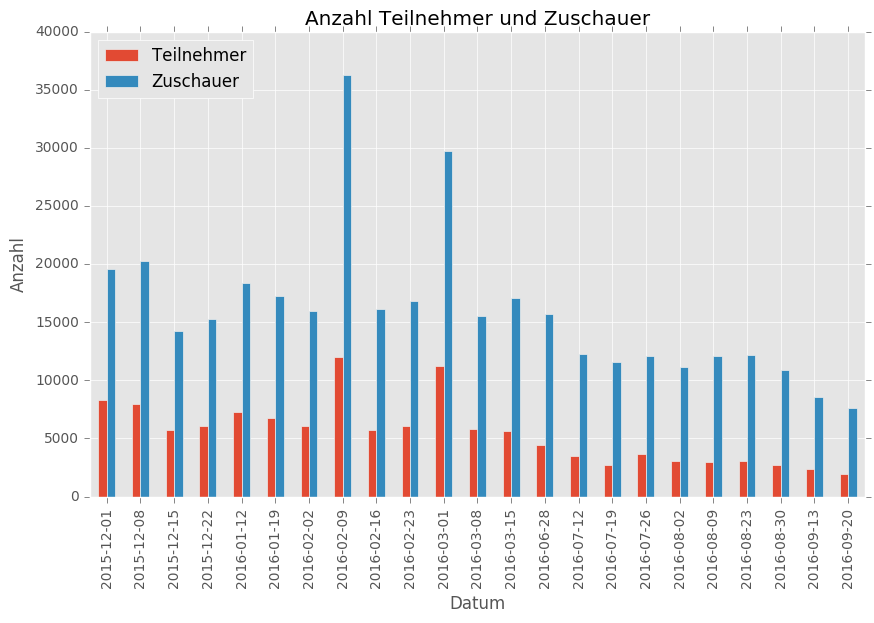

In [12]:
plot = joinedData[['participants', 'viewers']].plot(kind='bar', figsize=(10, 6), legend=False, title='Anzahl Teilnehmer und Zuschauer')
plot.set_xlabel('Datum')
plot.set_ylabel('Anzahl')

legend = plot.legend(loc=2)
legend.get_texts()[0].set_text('Teilnehmer')
legend.get_texts()[1].set_text('Zuschauer')

plot

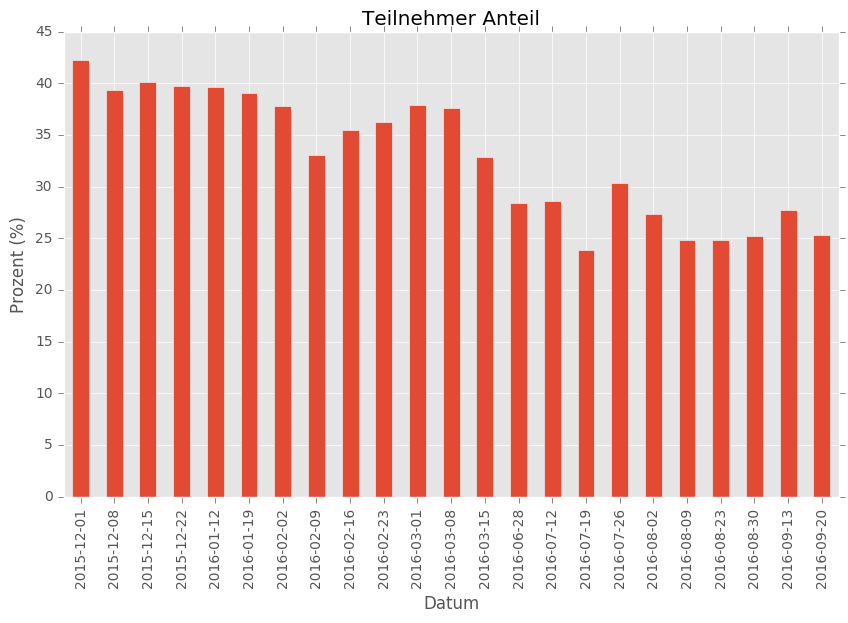

In [13]:
plot = joinedData['ratio'].plot(kind='bar', figsize=(10, 6), legend=False, title='Teilnehmer Anteil')
plot.set_xlabel('Datum')
plot.set_ylabel('Prozent (%)')

plt.ylim(ymin=0)

plot